<a href="https://colab.research.google.com/github/AotinianoZ/TrasnferLearning_CNN/blob/main/Clasficaci%C3%B3n_Flores_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de Flores con Transfer Learning

# Importar


Algunas librerias para importar que hemos visto anteriormente lo único nuevo es **tensorflow_hub** del cual Colab hace mucho uso.

In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [28]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Inicio: Descargar la dataset de flores usando Tensorflow Datasets

En la celda siguiente descargaremso el dataset Flores usando TensorFlow Dataset como anteriormente lo realizamos. Si nosotros miramos la [TensorFlow Datasets documentation](https://www.tensorflow.org/datasets/datasets#tf_flowers) vermos que el nombre del dataset de Flores es `tf_flowers`. Podemos además ver que el dataset esta solo dividido en set Entrenamiento. Deberemos usar `tfds.splits` para separar en un set de `training_set` y `validation_set`. Elegiremos separación `[70, 30]` en el cual 70% corresponde al `training_set` y 30% al `validation_set`. Luego cargaremos dataset `tf_flowers` usando `tfds.load`. Debemos asegurar que la función `tfds.load` usa todos los parámetros necesarios, y además verificar el retorno de la data en la información, así podremos entender el dataset completo.


In [29]:
(training_set, validation_set), dataset_info =  tfds.load(
    "tf_flowers",
    split = ["train[:70%]", "train[70%:]"],
    with_info=True,
    as_supervised=True
)

# Imprimir Información acerca del dataset Flores

Ahora que ya hemos descargado el dataset, usaremos la información para imprimir el número de clases del dataset, y además escribir un poco de código para contar cuantas imagenes existen en los sets de entrenamiento y validación.

In [30]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



Las images en el dataset Flores **no son del mismo tamaño**.

In [31]:
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


# Reformatear imagenes y crear batches

En la celda siguiente crearemos una función que reformatea todas las imagenes a resolución espera de **MobileNet** (*usaremos este objeto para realizar el transfer learning :)*) (224, 224) y lo normalizaremos. La función deberá tomar una `image` y una `label` como argumento y deberá retornar la nueva `image` y la correspondiente `label`. Luego crearemos batches de entrenamiento y validación de tamaño *32*.


In [42]:
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1) 

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

# Realizando Simple Transfer Learning con TensorFlow Hub

Ahora usaremos *TensorFlow Hub* para hacer el **Transfer Learning**. Recordar, que en el transfer learning usamos parte de un **modelo ya entrenado** Y cambiamos la *capa final*, o muchas capas del modelo, luego reentrenaremos estas capas como nuestro propio dataset :).

### Crearemos un extractor de caracteristicas

En la celda siguiente crearemos un `feature_extractor` usando *MobileNet v2*. Recordar que el modelo parcial desde TensorFlow Hub (sin la capa de clasificación) es denominado un **vector de caracteristicas**. Ir a [TensorFlow Hub documentation](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) para ver la lista disponible de vectores de características. Hacemos click en `tf2-preview/mobilenet_v2/feature_vector`. Antes de realizar este trabajo se reviso el URL indicado. Finalmente, se creo `feature_extractor` usando `hub.KerasLayer` con el correcto parámetro de `input_shape`.



In [43]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))

### Congelando el Modelo Pre-entrenado

En la celda siguiente se 'congelo' las variables en la capa de *feature extractor*, así que el entrenamiento solo modifica la capa final de clasificación.


In [44]:
feature_extractor.trainable = False

### Agregar el cabezal de clasificación

En la celda siguiente creamos un modelo `tf.keras.Sequential`, y agregamos un modelo pre-entrenado y la nueva capa de clasificación. La capa de clasificación debe ser el **mismo número de clase** de nuestro dataset Flores. Finalmente imprimimos el sumario del modelo Sequencial.


In [45]:
feature_extractor

In [46]:
train_batches

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [47]:
validation_batches

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [48]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(num_classes)
])

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________



### Entrenando el Modelo

En la celda siguiente entrenamos el modelo como cualquier otro, primero usaremos `compile` y luego `fit`. Debemos asegurarnos que usamos parámetros propios cuando aplicamos ambos métodos. El entrenamiento para 10 epochs.


In [49]:
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ["accuracy"]
)
EPOCHS = 10

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
81/81 [==============================] - 14s 121ms/step - loss: 0.7812 - accuracy: 0.7209 - val_loss: 0.4523 - val_accuracy: 0.8529
Epoch 2/10
81/81 [==============================] - 9s 107ms/step - loss: 0.3827 - accuracy: 0.8719 - val_loss: 0.3700 - val_accuracy: 0.8701
Epoch 3/10
81/81 [==============================] - 9s 107ms/step - loss: 0.3060 - accuracy: 0.9042 - val_loss: 0.3304 - val_accuracy: 0.8910
Epoch 4/10
81/81 [==============================] - 9s 107ms/step - loss: 0.2564 - accuracy: 0.9206 - val_loss: 0.3117 - val_accuracy: 0.8937
Epoch 5/10
81/81 [==============================] - 9s 106ms/step - loss: 0.2187 - accuracy: 0.9338 - val_loss: 0.3023 - val_accuracy: 0.8955
Epoch 6/10
81/81 [==============================] - 9s 106ms/step - loss: 0.1938 - accuracy: 0.9475 - val_loss: 0.2898 - val_accuracy: 0.8992
Epoch 7/10
81/81 [==============================] - 9s 106ms/step - loss: 0.1709 - accuracy: 0.9525 - val_loss: 0.2807 - val_accuracy: 0.9074
Epoch

Podemos ver que conseguimos *accuracy* validación **~88%** con solo 10 epochs de entrenamiento, esto considero **asombroso**. Este es una *enorme* mejora del modelo creado anteriormente, donde conseguirmos aproximadamente **~78%** de *accuracy* con 100 epochs (se usó data augmentation y variedad de técnicas para mejorar el modelo de predicción). La razón de esta diferencia es que MobilNet v2 fue cuidadosamente diseñado en el tiempo por **expertos**, luego de entrenar dataset masivos (ImageNet).



# Ploteo de Gráficos de Entrenamiento y Validación

En la celda siguiente, plotea el entramiento y validación con los gráficos de accuracy/loss.

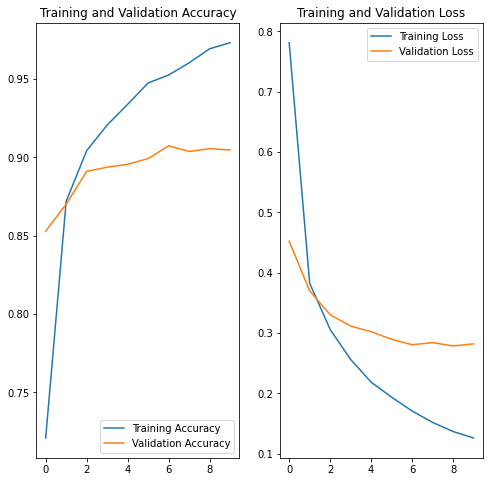

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Es resaltante que la validación performa es mejor que el entrenamiento performa, correcto desde el inicio al final de la ejecución.

Una de las razones es performa es medida al final de los epochs, pero el entrenamiento performa es el promedio de los valores a través de epochs.

La mayor razón es pensada porque reusamos una larga parte de *MobileNet* el cuale está entrenado con images de Flores.


# Revisar Predicciones:

En la celda siguiente conseguiremos los nombre de las etiquetas desde la información del dataset y lo converterimes en un Numpy array. Imprimiremos el arreglo para asegurarnos los nombre de etiquetas son correctos.


In [51]:
class_names = np.array(dataset_info.features['label'].names)

print(class_names)


['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


### Crear una Batch de Imagen y hacer predicciones

En la celda siguiente, usamos la función `next()` para crear una `image_batch` y su correspondiente `label_batch`. Convertiremos ambos `image_batch` y `label_batch` ha arreglos numpy usando el método `.numpy()`. Luego usaremos el método `.predict()` para ejecutar el batch de imagen a través del modelo y hacer predicciones. Después, usaremos la función `np.argmax()` para conseguir los índices de las mejores predicciones para cada imagen. Finalmente, convertiremos los indices de mejor predicción en clases de nombre.


In [52]:
image_batch, label_batch = next(iter(train_batches))


image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)


['roses' 'dandelion' 'tulips' 'roses' 'dandelion' 'dandelion' 'sunflowers'
 'daisy' 'roses' 'dandelion' 'tulips' 'sunflowers' 'dandelion' 'dandelion'
 'dandelion' 'dandelion' 'dandelion' 'daisy' 'sunflowers' 'tulips'
 'sunflowers' 'tulips' 'dandelion' 'roses' 'dandelion' 'tulips' 'daisy'
 'dandelion' 'sunflowers' 'sunflowers' 'dandelion' 'roses']


### Imprimiendo True Labels y Predicted Indices

En la celda siguiente, imprimiremos las etiquetas verdadero y el indice de etiquetas predecido.

In [53]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [4 0 2 4 0 0 3 1 4 0 2 3 0 0 0 0 0 1 3 2 3 2 0 4 0 2 1 0 3 3 0 4]
Predicted labels:  [4 0 2 4 0 0 3 1 4 0 2 3 0 0 0 0 0 1 3 2 3 2 0 4 0 2 1 0 3 3 0 4]


# Plotear Predicciones del Modelo

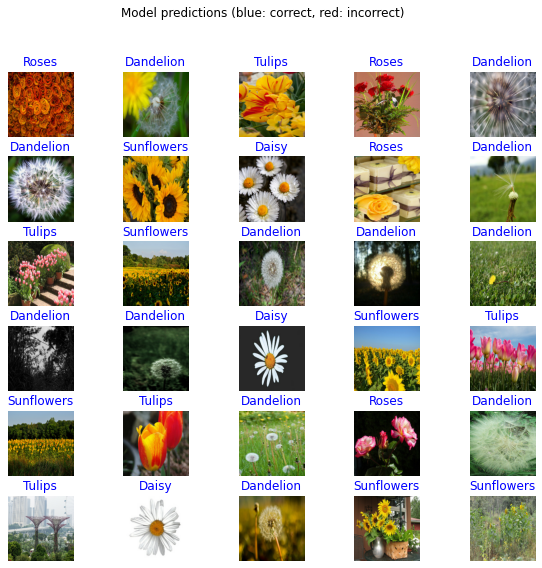

In [54]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

# Mejorar el Transfer Learning con el Inception Model

Por úttimo se me ocurrió mejorar esto con el Inception Model ir a [TensorFlow Hub documentation](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) y click en `tf2-preview/inception_v3/feature_vector`. Este vector corresponde al modelo **Inception v3 model**. En la celda siguiente, usaremos transfer learning para crear una CNN que usa el Inception v3 como el modelo preentrenado para clasificar imagenes desde el dataset de Flores. La entrada de inception es *299x299* pixeles. Compararemos las precisiones entre :

**Inception v3 ** Vs. **MobileNet v2**.

In [34]:
IMAGE_RES = 299

(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:70%]', 'train[70%:]'],
)
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
  input_shape=(IMAGE_RES, IMAGE_RES, 3),
  trainable=False)

model_inception = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])

model_inception.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [35]:
model_inception.compile(
  optimizer='adam', 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6

history = model_inception.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 75s 468ms/step - loss: 0.7868 - accuracy: 0.7155 - val_loss: 0.4587 - val_accuracy: 0.8574
Epoch 2/6
81/81 [==============================] - 33s 409ms/step - loss: 0.3946 - accuracy: 0.8813 - val_loss: 0.3631 - val_accuracy: 0.8783
Epoch 3/6
81/81 [==============================] - 33s 409ms/step - loss: 0.3158 - accuracy: 0.9019 - val_loss: 0.3155 - val_accuracy: 0.8974
Epoch 4/6
81/81 [==============================] - 33s 410ms/step - loss: 0.2595 - accuracy: 0.9225 - val_loss: 0.3056 - val_accuracy: 0.8965
Epoch 5/6
81/81 [==============================] - 33s 409ms/step - loss: 0.2319 - accuracy: 0.9299 - val_loss: 0.2822 - val_accuracy: 0.9010
Epoch 6/6
81/81 [==============================] - 33s 409ms/step - loss: 0.2041 - accuracy: 0.9443 - val_loss: 0.2912 - val_accuracy: 0.8992


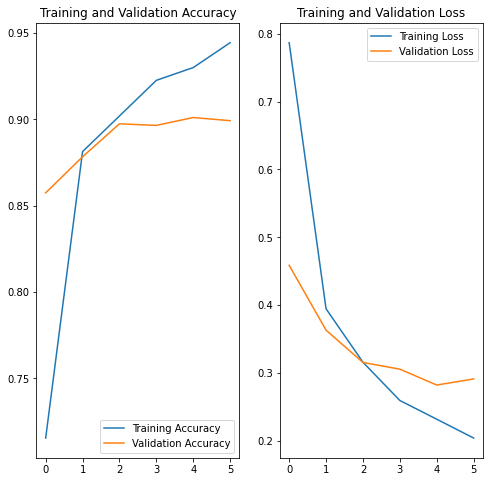

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
class_names = np.array(dataset_info.features['label'].names)

print(class_names)


['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [39]:
image_batch, label_batch = next(iter(train_batches))


image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model_inception.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

['dandelion' 'roses' 'dandelion' 'dandelion' 'roses' 'tulips' 'roses'
 'daisy' 'dandelion' 'daisy' 'sunflowers' 'sunflowers' 'tulips'
 'sunflowers' 'dandelion' 'dandelion' 'daisy' 'sunflowers' 'roses'
 'tulips' 'tulips' 'roses' 'daisy' 'roses' 'dandelion' 'sunflowers'
 'sunflowers' 'daisy' 'roses' 'sunflowers' 'roses' 'roses']


In [40]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [0 4 0 0 4 2 1 1 0 1 3 2 2 3 0 0 1 3 4 2 2 4 1 4 0 3 3 1 4 3 2 4]
Predicted labels:  [0 4 0 0 4 2 4 1 0 1 3 3 2 3 0 0 1 3 4 2 2 4 1 4 0 3 3 1 4 3 4 4]


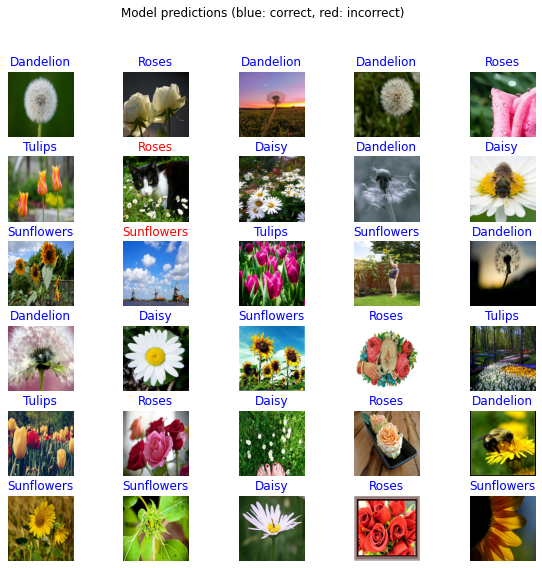

In [41]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

# Conclusiones

* Usar los **transfer learning** mejoran mucho la velocidad de procesamiento y la precisión con una cantidad mucho menor de batches, además nos permiten ahorrar mucho tiempo al momento de un análisis preliminar.

* La mejora del uso de transfer learning mejoró la **accuracy** de ~78% hasta ~90%.

* Al comparar modelos de **transfer learning** (Inception v3 y MobilNet v2) nos dio mejores resultados en aunque casi no hay diferencia MobilNet v2 (~91%).

* La idea de probar y comparar nuevos modelos y cambios en la estructura de la neurona puede proporcionar mejoras significativas.

# Recomendaciones

* No todos los tipos de data se adecuan a los modelos de transfer learning.

* Se requiere trabajos de muchos expertos y validados en el tiempo para usar el transfer learning (alguien que haya trabajado previamente), por lo cual se hace escaso para otros tipos de trabajos como el de Ingeniería Geológica (en mi caso).